In [1]:
import sys
sys.path.append('..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import dvc.api
import plotly.graph_objects as go

from messis.dataloader import GeospatialDataModule


params = dvc.api.params_show()

In [3]:
N_FOLDS = params['number_of_folds']

In [4]:
folds = []
for i in range(N_FOLDS):
    val_fold = (i + 1) % N_FOLDS

    data_module = GeospatialDataModule(data_dir='../data/',
                                       train_folds=list(set(range(N_FOLDS)) - {i, val_fold}),
                                       val_folds=[val_fold],
                                       test_folds=[i],
                                       batch_size=12,
                                       num_workers=1,
                                       debug=True,
                                       subsets=None)

    data_module.setup()
    folds.append(data_module.test_dataset)

Loading mean/std stats from ../data/chips_stats.yaml
Stats with selected test fold 2: {'mean': [569.9610595703125, 661.4386596679688, 404.933349609375, 2936.87890625, 1868.8929443359375, 1151.079833984375], 'n_chips': 62, 'std': [428.7176513671875, 355.9818420410156, 306.58673095703125, 1186.1724853515625, 603.5745849609375, 530.5262451171875]} over 3 timesteps.
Stats with selected test fold 3: {'mean': [557.8272094726562, 651.3617553710938, 400.717041015625, 2919.11083984375, 1841.9622802734375, 1124.7381591796875], 'n_chips': 65, 'std': [452.02374267578125, 383.55682373046875, 339.2447814941406, 1216.829833984375, 616.3052978515625, 539.1441650390625]} over 3 timesteps.
Stats with selected test fold 4: {'mean': [550.4143676757812, 646.3507690429688, 394.1318664550781, 2887.46533203125, 1825.043701171875, 1117.1475830078125], 'n_chips': 66, 'std': [432.0943908691406, 358.8883972167969, 301.88726806640625, 1267.31591796875, 664.5475463867188, 555.0609741210938]} over 3 timesteps.
Stats

In [5]:
pixels_by_tier_category_fold = [] # list for each fold: dict with tier as key: dict with category as key: pixel count as value
for i in range(N_FOLDS):
    print(f"Processing fold {i}")
    pixels_by_tier_category = {
        "tier1": {},
        "tier2": {},
        "tier3": {}
    }
    for batch in tqdm(folds[i]):
        targets = batch[1][0]
        for j, tier in enumerate(pixels_by_tier_category.keys()):
            # get the unique values and their counts
            unique, counts = targets[j].unique(return_counts=True)
            # create a dictionary with the unique values and their counts
            for clazz, count in zip(unique, counts):
                if clazz.item() in pixels_by_tier_category[tier]:
                    pixels_by_tier_category[tier][clazz.item()] += count.item()
                else:
                    pixels_by_tier_category[tier][clazz.item()] = count.item()
            #unique_counts = {int(clazz): int(count) for clazz, count in zip(unique, counts)}
            #print(unique_counts)
            
            # add the counts to the corresponding tier
    pixels_by_tier_category_fold.append(pixels_by_tier_category)

Processing fold 0


100%|██████████| 69/69 [00:04<00:00, 15.87it/s]


Processing fold 1


100%|██████████| 61/61 [00:03<00:00, 16.18it/s]


Processing fold 2


100%|██████████| 62/62 [00:03<00:00, 17.10it/s]


Processing fold 3


100%|██████████| 65/65 [00:03<00:00, 16.97it/s]


Processing fold 4


100%|██████████| 66/66 [00:04<00:00, 15.77it/s]


Processing fold 5


100%|██████████| 64/64 [00:04<00:00, 15.24it/s]


In [6]:
print(f"len(pixels_by_tier_category_fold): {len(pixels_by_tier_category_fold)}")
print(f"len(pixels_by_tier_category_fold[0]): {len(pixels_by_tier_category_fold[0])}")
print(f"len(pixels_by_tier_category_fold[0]['tier1']): {len(pixels_by_tier_category_fold[0]['tier1'])}")
print(f"pixels_by_tier_category_fold[0]['tier1']: {pixels_by_tier_category_fold[0]['tier1']}")

len(pixels_by_tier_category_fold): 6
len(pixels_by_tier_category_fold[0]): 3
len(pixels_by_tier_category_fold[0]['tier1']): 6
pixels_by_tier_category_fold[0]['tier1']: {0: 2215697, 1: 678653, 2: 534392, 3: 20453, 4: 11514, 5: 1435}


In [7]:
import json
dataset_info = json.load(open('../data/dataset_info.json'))

dataset_info["tier1"]

['Background',
 'Grassland',
 'Field crops',
 'Orchards',
 'Special crops',
 'Forest']

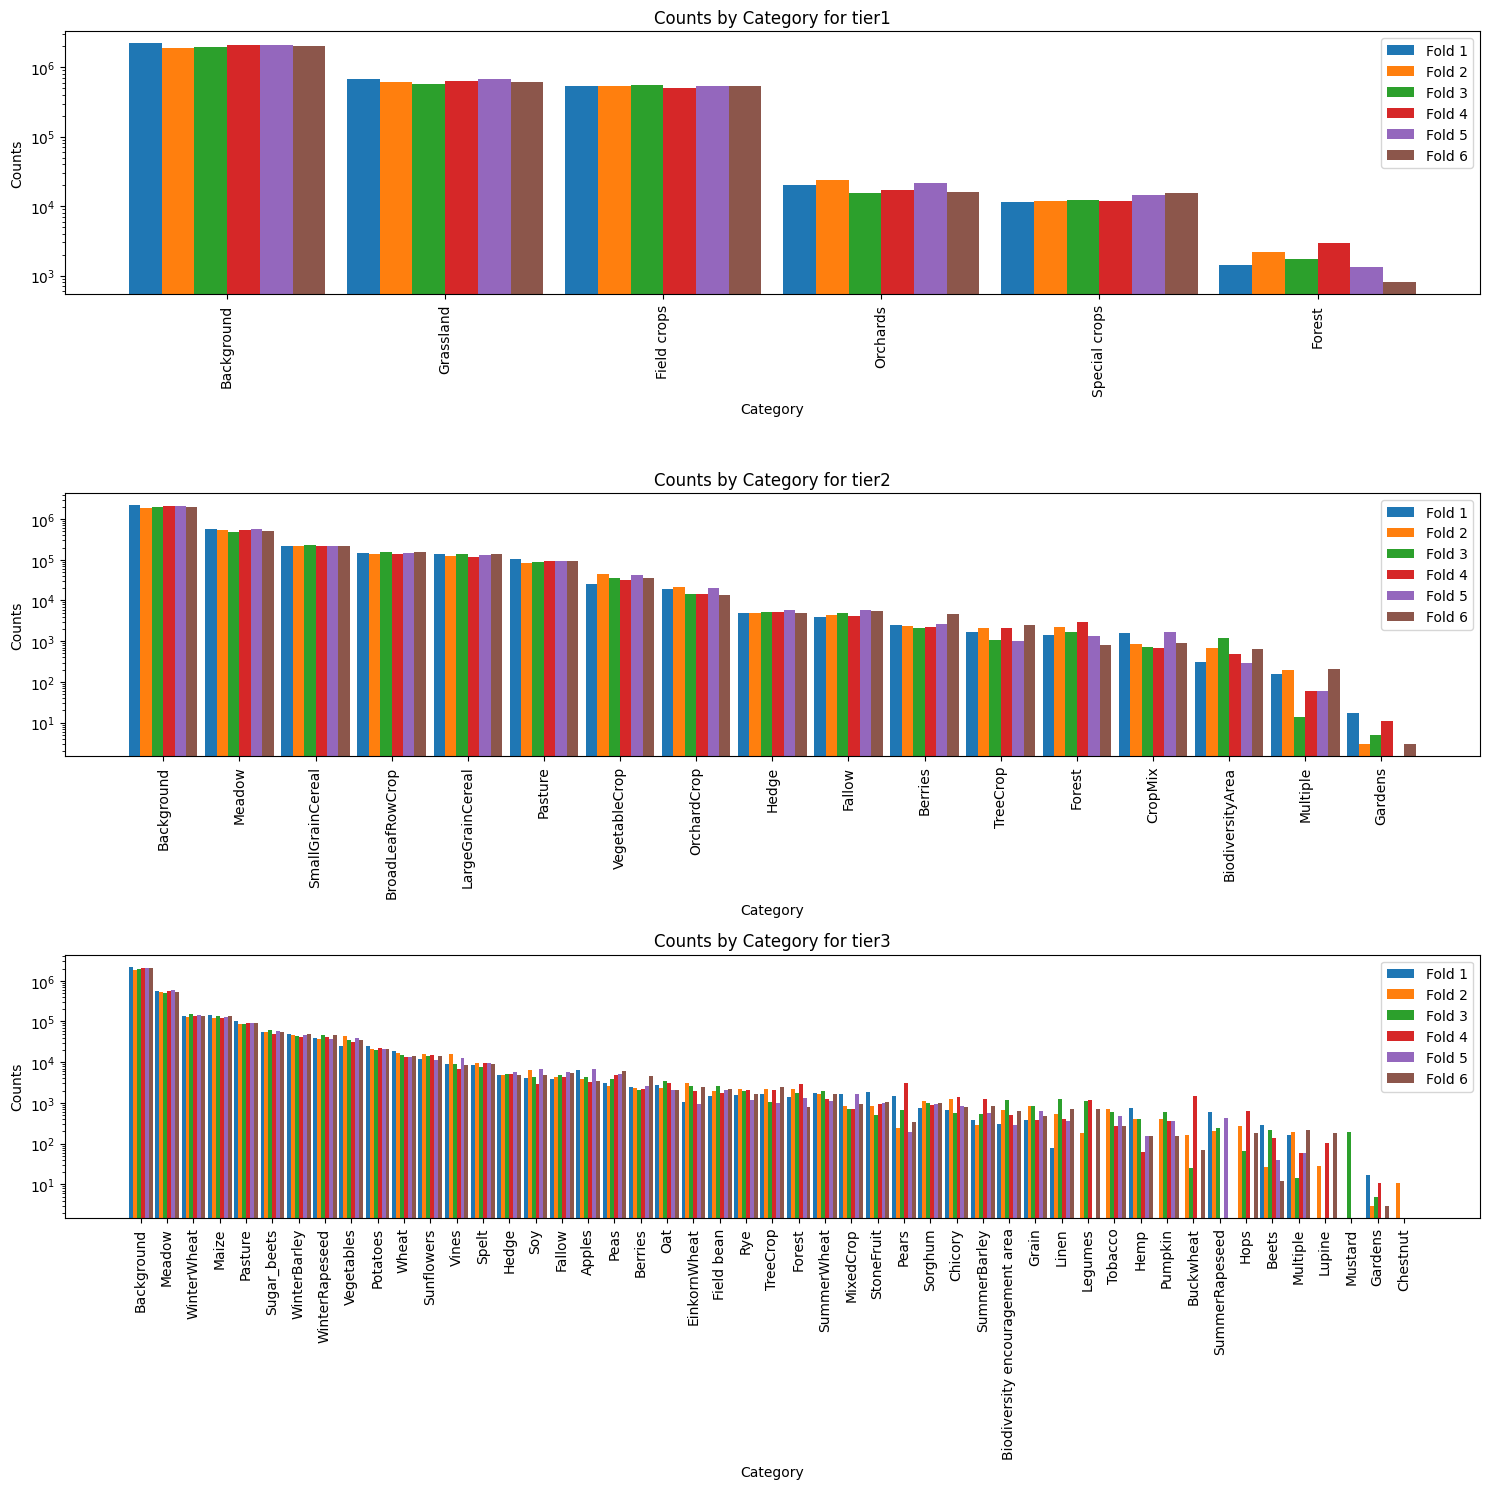

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 15), sharex=False)
fig.subplots_adjust(hspace=0.4)

for ax, tier in zip(axes, ["tier1", "tier2", "tier3"]):
    categories = set().union(*[pixels_by_tier_category_fold[i][tier].keys() for i in range(N_FOLDS)])
    index = np.arange(len(categories))
    bar_width = 0.15
    counts_by_fold = []
    for fold in range(N_FOLDS):
        counts = [pixels_by_tier_category_fold[fold][tier].get(cat, 0) for cat in categories]
        counts_by_fold.append(counts)
    # aggregate counts by category
    counts = np.sum(counts_by_fold, axis=0)
    # order the categories and counts by counts
    categories = [cat for _, cat in sorted(zip(counts, categories), key=lambda pair: pair[0], reverse=True)]
    for fold in range(N_FOLDS):
        counts = [pixels_by_tier_category_fold[fold][tier].get(cat, 0) for cat in categories]
        ax.bar(index + fold * bar_width, counts, bar_width, label=f'Fold {fold+1}')
    
    ax.set_xlabel('Category')
    ax.set_ylabel('Counts')
    ax.set_yscale('log')
    ax.set_title(f'Counts by Category for {tier}')
    ax.set_xticks(index + bar_width * (N_FOLDS - 1) / 2)
    labels = [dataset_info[tier][cat] for cat in categories]
    ax.set_xticklabels(labels, rotation=90)
    ax.legend()

plt.tight_layout()
plt.show()

In [9]:
tier3_to_tier1 = dataset_info["tier3_to_tier1"] # array where index is tier3 and value is tier1
tier3_to_tier2 = dataset_info["tier3_to_tier2"] # array where index is tier3 and value is tier2
# create tier_2 to tier_1 mapping
tier2_to_tier1 = [0] * (max(tier3_to_tier2) + 1)
for tier3 in range(len(tier3_to_tier2)):
    tier2 = tier3_to_tier2[tier3]
    tier1 = tier3_to_tier1[tier3]
    tier2_to_tier1[tier2] = tier1

In [10]:
print(tier3_to_tier2) # array where index is tier3 and value is tier2
print(tier2_to_tier1) # array where index is tier2 and value is tier1

[0, 1, 2, 3, 4, 5, 2, 5, 6, 5, 2, 5, 7, 2, 8, 9, 7, 5, 5, 2, 10, 2, 5, 2, 2, 11, 7, 12, 3, 2, 6, 7, 2, 13, 14, 5, 5, 6, 5, 2, 5, 5, 7, 5, 15, 5, 5, 16, 7]
[0, 1, 2, 2, 1, 2, 2, 3, 4, 4, 4, 3, 2, 1, 5, 4, 4]


In [11]:
# aggregate all folds of pixels_by_tier_category_fold
pixels_by_tier_category = {
    "tier1": {},
    "tier2": {},
    "tier3": {}
}
for tier in pixels_by_tier_category.keys():
    for fold in range(N_FOLDS):
        for clazz, count in pixels_by_tier_category_fold[fold][tier].items():
            if clazz in pixels_by_tier_category[tier]:
                pixels_by_tier_category[tier][clazz] += count
            else:
                pixels_by_tier_category[tier][clazz] = count

pixels_by_tier_category # dict with each tier as key. The value is a dict again with the category as tier and the pixel count as value

{'tier1': {0: 12200762, 1: 3801809, 2: 3214370, 3: 113969, 4: 76799, 5: 10403},
 'tier2': {0: 12200762,
  1: 3239274,
  2: 1323210,
  3: 790808,
  4: 558928,
  5: 878427,
  7: 103518,
  8: 28732,
  9: 30923,
  13: 3607,
  10: 16406,
  12: 6456,
  11: 10451,
  6: 215469,
  14: 10403,
  15: 699,
  16: 39},
 'tier3': {0: 12200762,
  1: 3239274,
  2: 842024,
  3: 785191,
  4: 558928,
  5: 335164,
  7: 249109,
  9: 130231,
  14: 28732,
  15: 30923,
  16: 28113,
  17: 29414,
  23: 9350,
  26: 6217,
  33: 3607,
  10: 92468,
  13: 54044,
  20: 16406,
  27: 6456,
  6: 277369,
  11: 83012,
  24: 10679,
  12: 62020,
  19: 15845,
  25: 10451,
  8: 208066,
  22: 12066,
  32: 3879,
  18: 25894,
  31: 6006,
  41: 1473,
  28: 5617,
  21: 12198,
  43: 720,
  40: 1945,
  30: 5502,
  29: 3583,
  34: 10403,
  44: 699,
  35: 3353,
  47: 39,
  39: 1771,
  37: 1901,
  45: 320,
  38: 2351,
  36: 3186,
  48: 11,
  42: 1151,
  46: 189}}

In [12]:
# Prepare data for Sankey diagram
node_labels = ["Vegetation"]

# Create labels for tier 1 nodes
tier1_labels = [f"1 - {dataset_info['tier1'][i]}" for i in list(pixels_by_tier_category['tier1'].keys()) if i != 0]
node_labels.extend(tier1_labels)

# Create labels for tier 2 nodes
tier2_labels = [f"2 - {dataset_info['tier2'][i]}" for i in list(pixels_by_tier_category['tier2'].keys()) if i != 0]
node_labels.extend(tier2_labels)

# Create labels for tier 3 nodes
tier3_labels = [f"3 - {dataset_info['tier3'][i]}" for i in list(pixels_by_tier_category['tier3'].keys()) if i != 0]
node_labels.extend(tier3_labels)

# Create source and target lists based on the provided relationships
sources = []
targets = []
values = []

# Tier1 to Vegetation links
for i, t1_index in enumerate(tier1_labels):

    sources.append(0)  # Index of Vegetation node
    targets.append(i+1)  # Adjust index for tier 1 node
    values.append(pixels_by_tier_category['tier1'][i+1])


# Tier2 to Tier1 links
for i, t1_index in enumerate(tier2_to_tier1):
    if i == 0:
        continue
    targets.append(len(tier1_labels) + i)  # Adjust index for tier 2 node
    sources.append(t1_index)  # Adjust index for tier 1 node
    values.append(pixels_by_tier_category['tier2'][i])

# Tier3 to Tier2 links
for i, t2_index in enumerate(tier3_to_tier2):
    if i == 0:
        continue
    targets.append(len(tier1_labels) + len(tier2_labels) + i)  # Index of tier 3 node
    sources.append(len(tier1_labels) + t2_index)  # Adjust index for tier 2 node
    values.append(pixels_by_tier_category['tier3'][i])

# Create the Sankey diagram using Plotly
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=node_labels
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values
    )
)])

fig.update_layout(title_text="<b>Original Label Hierarchy</b> (Bands represent number of pixels in dataset)", font_size=12, height=750)
fig.show()